7 0 1825
0 1.760769598383167e-07
1 1.760769598256564e-07
2 1.7607695979629433e-07
3 1.760769597569493e-07
4 1.7607695970288073e-07
5 1.760769596480438e-07
6 1.7607695958161851e-07
7 1.760769595098757e-07
8 1.7607695941962283e-07
9 1.7607695933268675e-07
There is no Jacobian sprectrum saved file here: ..
load_sing_pairs passed to False.


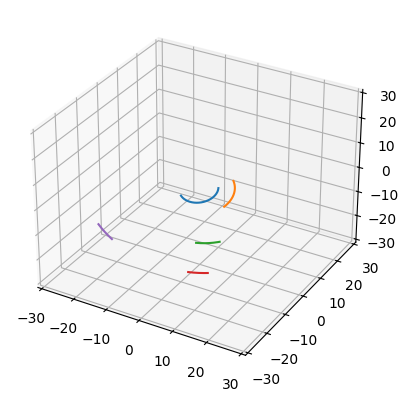

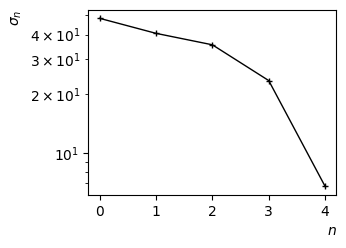

There is no Jackpot manifold saved file here: saves/solar_system/solar_system_d_1_eps_7e-06_n_101_l_1e-04.manifold.
load_manifold passed to False.


param| pos:[7,], iter: 1, loss: 1.984e-07, snr: 121.901, grad: 3.019e-03:  88%|████████▊ | 89/101 [04:03<00:30,  2.56s/it] 

In [ ]:
# ########################################################
# ################# JACKPOT TEMPLATE #####################
# ########################################################

import torch
from jackpot import Jackpot

params = {
    "experiment_name": "jmlr_inverse_problem",
    "save_plot": True,
    "n_singular_pairs": 5,
    "max_compute_time": 3600,
    "load_sing_pairs": True,
    "save_sing_pairs": True,
    "D": 1,
    "epsilon": 1e-1,
    "n_points_per_axis": 101,
    "grid_length": 1e-4,
    "load_manifold": True,
    "save_manifold": True,
}

# ------------------------------------
#  DIRECT MODEL 
# ------------------------------------

import torch.optim as optim
import torch

import matplotlib.pyplot as plt
from pathlib import Path

import deepinv as dinv
# from utils_codes.utils import neurips_mode, default_plot_styles, save_this_plot

######## IMPORT THE MODEL #################################
from article_examples.solar_system.solar_system_functions import SolarModel

import imageio.v3 as iio

from tqdm import tqdm
import os

# Device & dtype setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64
factory_kwargs = {"device": device, "dtype": dtype}
torch.manual_seed(0)

# Example: diagonal linear operator with shift
n_planets = 5
what_is_param = ["mass"] #["mass", "position", "speed"]
dt = 7
Tinit, Tfin = 0, 365*5

solar_model = SolarModel(n_planets=n_planets, what_is_param=what_is_param,
                         solar_mass_included=False, device=device, dtype=dtype,
                         export_speed=False)

AU_to_km = 6.6846e-9
params["epsilon"] = 1000 * AU_to_km   # 1000km error

x_true = solar_model.param_default
print(dt, Tinit, Tfin)
plot_output = solar_model.plot_curves
plot_inputs = solar_model.plot_inial_planets

Phi = solar_model.generate_Phi(Tinit, Tfin, dt)
plot_output(Phi(x_true), lims=30)

y_true = Phi(x_true)
y = y_true + params["epsilon"] * torch.randn_like(y_true)

# %% Gradient to find the best model x0 given the data
x0 = x_true.clone().detach()
x0.requires_grad = True
niter_grad = 10

optimizer = optim.SGD([x0], lr=1e-11, momentum=0.9)

for k in range(niter_grad):
    optimizer.zero_grad()
    loss = torch.sum((Phi(x0) - y)**2)
    loss.backward()
    optimizer.step()
    print(k, loss.item())

y0 = Phi(x0)

x_est = x0.clone().detach()
# ------------------------------------


# ------------------------------------
# JACKPOT INITIALIZATION
# ------------------------------------
jack = Jackpot(Phi, x_est)

jack.set_params(**params)
# ------------------------------------


# ------------------------------------
# JACOBIAN SINGULAR SPECTRUM
# ------------------------------------
jack.jacobian_spectrum()

# Plot spectrum
jack.jacobian_spectrum_plot()
# ------------------------------------


# ------------------------------------
# JACKPOT MANIFOLD
# ------------------------------------
jack.manifold()

# Plot discrepancy
jack.plot_discrepancy(
    in_SNR=True,
    levels=[20, 30, 40],
    color_levels=["g", "b", "r"],
)
# ------------------------------------